# Exercise 07

## Changes to the Evacuation Model

To enable exercises about learning and prediction, the evacuation model has been modified:

* Add statistics about the number of agents escaped through each of the exits (EscapedWest, EscapedSouth, EscapedEast, EscapedNorth)
* Introduce `turnwhenblocked_prop`: with this probability agents turn when their path is blocked by other agents
* If an agent is blocked, its `nervousness` is increased by `NERVOUSNESS_INCREASE_BLOCKED` (default: 0.2)
* When `random_spawn` is `False`, agents are located at the left part of the room.
* With low probability (`SPEED_RECOVERY_PROBABILTY = 0.15`), agents with `speed==0` increase their speed again (otherwise they likely become completely inactive)
* Add possibility to predict crowds while turning
* Introduce agent memory to store agents' cooperativeness and the number of steps it took the agent to escape. This allows the learning of favorable values of cooperativeness accross model runs.
* Introduce learning of `cooperativeness`
* Introduce `switches` for agents to switch on/off various features (eg. predictcrowd) - not implemented on model level to facilitate parameter passing)
* Double wall thickness from 1 to 2 to simulate severe bottlenecks.

## Evaluation Code


In [1]:
from mesa.batchrunner import batch_run
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.insert(0,'../../abmodel')

from fire_evacuation.model import FireEvacuation
from fire_evacuation.agent import Human

unikcolors = [np.array((80,149,200))/255, np.array((74,172,150))/255,
                                                  np.array((234,195,114))/255, np.array((199,16,92))/255]
uniks = LinearSegmentedColormap.from_list( 'unik', unikcolors)



In [2]:
from app import page
page

Cannot show ipywidgets in text

In [3]:
def run_model(model_a, model_b, maxsteps = 100):
    fig = plt.figure(figsize=(12, 12))
    model_a.run(maxsteps)
    model_b.run(maxsteps)
    
    ax = fig.add_subplot(2, 1, 2)
    ax.set_xlabel("Steps")
    ax.set_ylabel("Number of escaped through the exit")
    da = model_a.datacollector.get_model_vars_dataframe()[['EscapedWest', 'EscapedSouth','EscapedEast', 'EscapedNorth']]
    db = model_b.datacollector.get_model_vars_dataframe()[['EscapedWest', 'EscapedSouth','EscapedEast', 'EscapedNorth']]
    da.columns = ['EscapedWest_A', 'EscapedSouth_A','EscapedEast_A', 'EscapedNorth_A']
    db.columns = ['EscapedWest_B', 'EscapedSouth_B','EscapedEast_B', 'EscapedNorth_B']
    da.plot(ax=ax, colormap=uniks, ls="solid")
    db.plot(ax=ax, colormap=uniks, ls="dashed")
    
def plot_results(results):
    data = pd.DataFrame(results)[['predictcrowd', 'Step', 'seed','EscapedWest', 'EscapedSouth','EscapedEast', 'EscapedNorth']].round(decimals=1)

    data = data.groupby(data['Step'].diff().lt(1).cumsum()) \
        .apply(lambda x: x.set_index('Step').reindex(range(1, 101)).transform(lambda x: x.fillna(x.max()))) \
        .reset_index(level=0, drop=True) \
        .reset_index()

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.set_ylabel("Escaped per exit")
    data[data['predictcrowd']==True].groupby(['Step']).agg("mean").drop(columns=['predictcrowd', 'seed']).plot(ax=ax, colormap=uniks, ls="solid")
    db = data[data['predictcrowd']==False].groupby(['Step']).agg("mean").drop(columns=['predictcrowd', 'seed'])
    db.columns = ['EscapedWest_NoPredict', 'EscapedSouth_NoPredict','EscapedEast_NoPredict', 'EscapedNorth_NoPredict']
    plot = db.plot(ax=ax, colormap=uniks, ls="dashed")

# Task 2 (Prediction in the evacuation model)

## Subtask 2.2

Currently, the time it takes to escape through a particular exit in the evacuation model (method `attempt_exit_plan()` in lines 387ff in `agent.py`) is predicted solely based on the distance from the current position to the exit door. How would you improve the prediction of time it takes to reach the exit? Try to sketch the required implementation in detail (<200 words). Provide pseudo code to illustrate your idea (learn how to write code in Markdown via *Help* > *Markdown reference*). Discuss your improvement in terms of cognitive load of a modelled actor. Implementing your proposal may help to find a suitable solution, but is no requirement. If you do so, consider implementing a switch to enable and disable your extention.

In reality, the time it takes to reach an exit is not only determined by the distance to the exit, but also by the number of agents in the way. 
Realisticly, agents in the way slow down the movement of other agents by pushing/ blocking them, so the time to reach the exit is longer if there are many agents in the way.
To improve the prediction, we could use the number of agents in the way as an additional feature. 

```python
def get_agents_in_the_way(self):
    agents_in_the_way = 0
    for agent in self.model.agents:
        if agent.pos in self.get_line(self.pos, self.planned_target.pos):   # get_line() returns a list of all positions between two points
            agents_in_the_way += 1
    return agents_in_the_way


def predict_time_to_exit(self, position, exit):
    # get the distance to the exit
    distance = len(self.get_line(position, exitdoor.pos))
    # get the number of agents in the way
    agents_in_the_way = self.get_agents_in_the_way()
    # calculate the time to reach the exit
    time_to_exit = distance + agents_in_the_way
    return time_to_exit

def attempt_exit_plan(self):
        self.planned_target = None

        if len(self.exits) > 0:
            if len(self.exits) > 1:  
                # If there is more than one exit known
                best_distance = None
                for exitdoor in self.exits.keys():
                    # Let's use Bresenham's to find the 'closest' exit
                    length = self.predict_time_to_exit(self.pos, exitdoor.pos))
                    if not best_distance or length < best_distance:
                        best_distance = length
                        self.planned_target = exitdoor

            else:
                self.planned_target = list(self.exits.keys())[0]

        elif self.turned == False:
            # If there's no fire-escape in sight, turn around
            self.turn()   

```

The cognitive load of the modelled actor is increased, as the agent now has to keep track of the number of agents in the way. 
Moreover, the get_line() function is currently called multiple times, which is not optimal in terms of computational efficiency.
This is a semi-realistic representation of the real world, where agents also have to keep track of other agents in the way.
If an agent would have an individual resistance to being pushed or likelihood to pushing/ blocking another agent, this could also be taken into account in the prediction and thus, the cognitive load would be even higher but the scenario would be more realistic.

## Subtask 2.3

When the switch `PREDICT_CROWD` is on, the turn() method (lines 346ff in agent.py) considers crowds such that the agent turns away from crowds. It therefore predicts the time it takes to escape from the number of agents in its field of vision (an agent does not consider that agents it perceives may head for different exits). Get a first impression whether this prediction helps by using the following code. Which three aspects can be obtained from the figure and should be considered for the analysis?

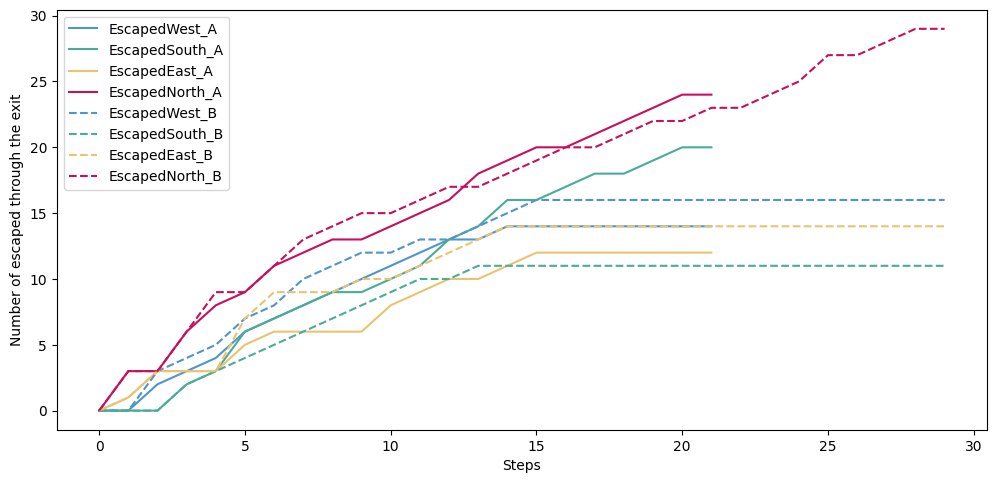

In [4]:
%matplotlib inline
# compare two single runs wrt. crowd prediction:
evacuation_a = FireEvacuation(floor_size = 14,
        human_count = 70,
        random_spawn = True,
        alarm_believers_prop = 0.7,
        max_speed = 2,
        cooperation_mean = 0.3,
        nervousness_mean = 0.5,
        predictcrowd = True,
        seed = 2)
evacuation_b = FireEvacuation(floor_size = 14,
        human_count = 70,
        random_spawn = True,
        alarm_believers_prop = 0.7,
        max_speed = 2,
        cooperation_mean = 0.3,
        nervousness_mean = 0.5,
        predictcrowd = False,
        seed = 2)

run_model(evacuation_a, evacuation_b, maxsteps = 100)

The three aspects that can be obtained from the figure and should be considered for the analysis are:
1. Escape north has the highest number of agents escaping, for both the cases with and without crowd prediction. This could be due to the fact that the north exit is the closest to the starting position (random, but constant because of seed) of the agents.
2. The no-crowd prediction case has longer simulation time, due to uneven/ scewed distribution of the agents to the exits and thus, more congestion.
This is intuitive, as the crowd prediction helps the agents to avoid congestion and thus, not all agents should take the same exit and consequently, escape faster.
3. For both cases, the number of agents escaping through two (for crowd prediction) or three (for no crowd prediction) exits stagnates after a certain number of steps. This could be due to the fact that the agents are to close to an exit to consider changing their path.

## Subtask 2.4

Comparing the feature of prediction for a single random seed is usually not sufficient. Specify the missing parameters and perform batch runs (50 seeds). Then, complement the function `analyse_significance_predictcrowd` to perfrom a t-test and visualise the distributions by boxplots. What is different when you set `random_spawn=False` (see description above)? Describe the results shortly, try to explain them and sketch a way to test your hypothesis (<200 words)!

In [5]:
import numpy as np

params = dict(
    floor_size=14,
    human_count=100,
    alarm_believers_prop = 0.1,
    max_speed = 2,
    random_spawn = [True, False],
    predictcrowd = [True, False],
    cooperation_mean = 0.3,
    nervousness_mean = 0.5,
    seed = [i for i in range(180)],   # increased number of seed, bc else every feature is considered non-significant
)

results = batch_run(
        FireEvacuation,
        parameters=params,
        iterations = 1,
        max_steps = 200,
    )

  0%|          | 0/720 [00:00<?, ?it/s]

# Explanation
Left plot is random_spawn == True, right plot is random_spawn == False. 
Grouped by predictcrowd using one of the columns 'EscapedWest', 'EscapedSouth','EscapedEast', 'EscapedNorth', 'Step', 'random_spawn'.

In [6]:
from scipy import stats

def analyse_significance_predictcrowd(data, title=""):

    print(f"Analysing {title}...")
    
    data = data.groupby(['predictcrowd', "seed", "random_spawn"]).agg("mean").reset_index()
    
    # implement t-test
    # predict_crowd vs no_predict_crowd
    samples1 = data[(data['predictcrowd']==True)][['EscapedWest', 'EscapedSouth','EscapedEast', 'EscapedNorth', 'Step', 'random_spawn']]
    samples2 = data[(data['predictcrowd']==False)][['EscapedWest', 'EscapedSouth','EscapedEast', 'EscapedNorth', 'Step', 'random_spawn']]
    

    t_test_stats = pd.DataFrame()
    for orientation in ['EscapedWest', 'EscapedSouth','EscapedEast', 'EscapedNorth', 'Step']:
        fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
        for rand_spawn in [True, False]:
            rvs1 = samples1[(samples1['random_spawn']==rand_spawn)]
            rvs2 = samples2[(samples2['random_spawn']==rand_spawn)]
            t_test_stats[orientation] = stats.ttest_ind(rvs1[orientation], rvs2[orientation])
        
        # Interpret the results:
        # print appropriate messages about the t-test result, giving the level of significance
            if t_test_stats[orientation][1] < 0.10: # p-value
                print(f"random_spawn = {rand_spawn}: The difference in the number of people escaping through the {orientation} exit is significant.")
            else:
                print(f"random_spawn = {rand_spawn}: The difference in the number of people escaping through the {orientation} exit is not significant.")
            print(f"random_spawn = {rand_spawn}: The p-value of {orientation} is: ", t_test_stats[orientation][1])
            
            data[(data['random_spawn']==rand_spawn)].boxplot(column=[orientation], by='predictcrowd', figsize = (12,6), ax=ax1 if rand_spawn else ax2)
        plt.title(f"random_spawn = {rand_spawn} - {orientation}")
        plt.show()
    None

Analysing Random spawn agents...
random_spawn = True: The difference in the number of people escaping through the EscapedWest exit is not significant.
random_spawn = True: The p-value of EscapedWest is:  0.20119217146970644
random_spawn = False: The difference in the number of people escaping through the EscapedWest exit is significant.
random_spawn = False: The p-value of EscapedWest is:  0.043787958666903985


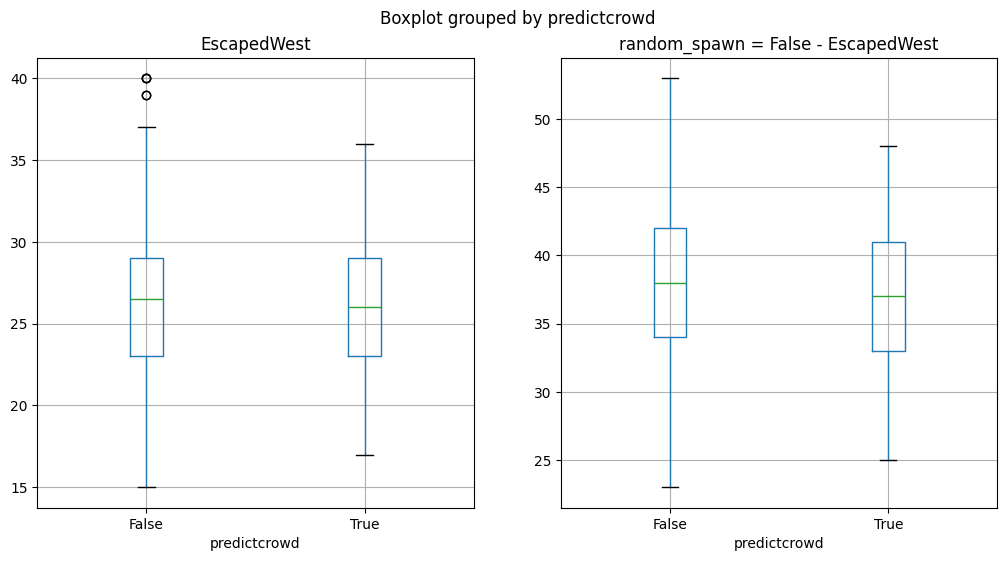

random_spawn = True: The difference in the number of people escaping through the EscapedSouth exit is not significant.
random_spawn = True: The p-value of EscapedSouth is:  0.9572177925859935
random_spawn = False: The difference in the number of people escaping through the EscapedSouth exit is significant.
random_spawn = False: The p-value of EscapedSouth is:  0.0725114232435164


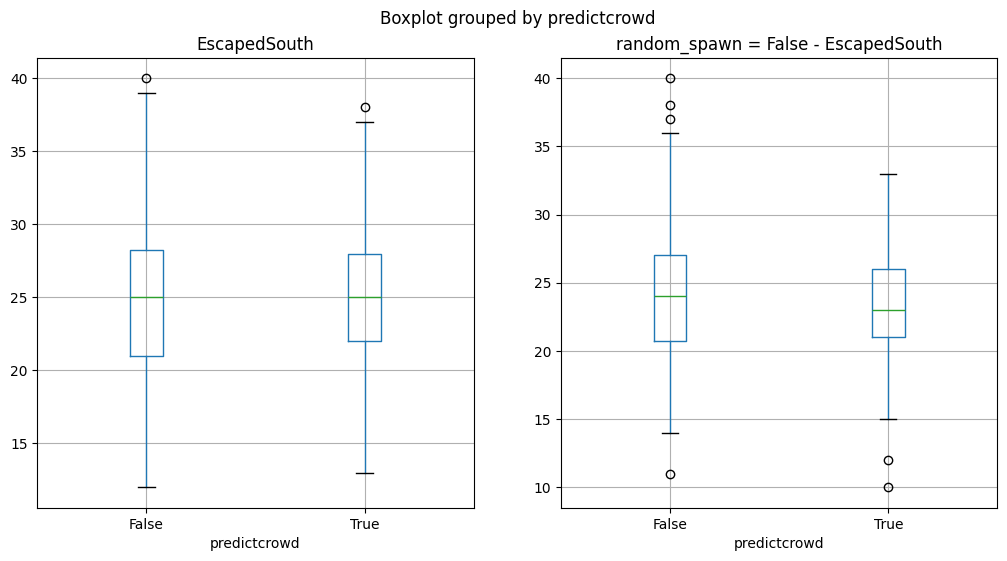

random_spawn = True: The difference in the number of people escaping through the EscapedEast exit is not significant.
random_spawn = True: The p-value of EscapedEast is:  0.5704585640889603
random_spawn = False: The difference in the number of people escaping through the EscapedEast exit is significant.
random_spawn = False: The p-value of EscapedEast is:  0.048603694604945895


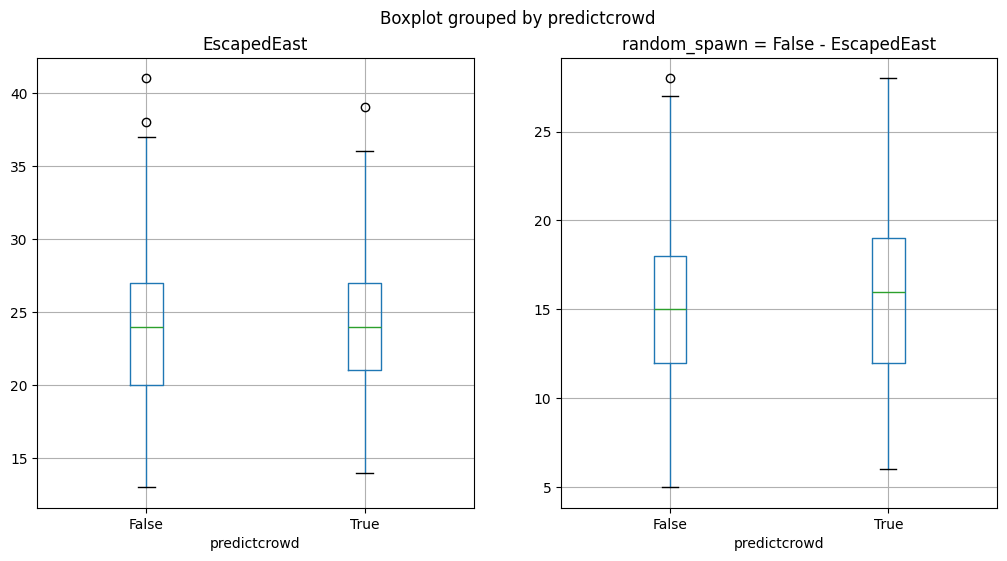

random_spawn = True: The difference in the number of people escaping through the EscapedNorth exit is not significant.
random_spawn = True: The p-value of EscapedNorth is:  0.5844553289521137
random_spawn = False: The difference in the number of people escaping through the EscapedNorth exit is significant.
random_spawn = False: The p-value of EscapedNorth is:  0.0245801419821888


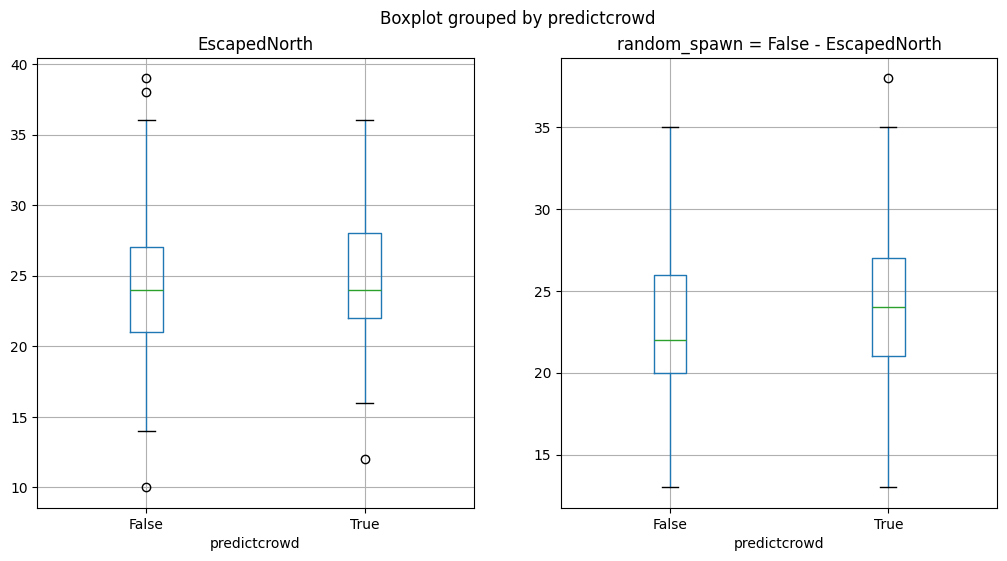

random_spawn = True: The difference in the number of people escaping through the Step exit is not significant.
random_spawn = True: The p-value of Step is:  0.6638845755598249
random_spawn = False: The difference in the number of people escaping through the Step exit is not significant.
random_spawn = False: The p-value of Step is:  0.7841183602972475


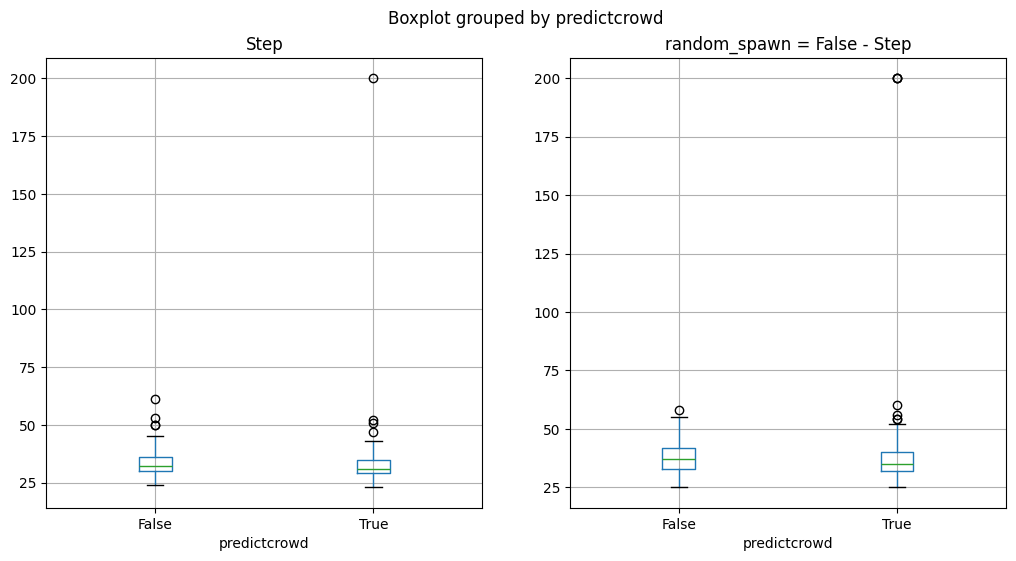

In [7]:
data = pd.DataFrame(results)
#data = data[data['random_spawn']==True]
analyse_significance_predictcrowd(data, title="Random spawn agents")

In [8]:
# data = pd.DataFrame(results)
# data = data[data['random_spawn']==False]
# analyse_significance_predictcrowd(data, title="Clustered agents")

# results
only difference: steps, all other columns show significant difference between the two samples
- random_spawn=True: no significant difference between the two samples
- random_spawn=False: significant difference between the two samples for every column except 'Step'
- random_spawn=False: von oben links nach unten rechts, also von nord nach süd, also von west nach ost einsetzen


# sketch a way to test your hypothesis
Hypothesis: The crowd prediction feature has no significant impact on the evacuation time (measured in overall steps, not per escape).
The crowd prediction feature has a significant impact on the distribution of agents over the different exits when the agents are NOT spawned randomly in the room.
When the agents are not spawned randomly in the room, the agents are are close to one (north) exit and thus, the crowd prediction feature should have a significant impact on the chosen exit due to the uneven distribution of the agents to the exits.
If the agents do not consider crowds to be an obstacle, they will all head for the same exit, otherwise they'll try to avoid crowds.
-> To test this hypothesis, we could run the model with and without the crowd prediction feature for a large number of seeds and compare the distribution over each exits for the two cases. We could then perform a t-test to determine if the difference in evacuation time is statistically significant. (this is what we did in the code above)

In [9]:
import numpy as np

params = dict(
    floor_size=14,
    human_count=100,
    alarm_believers_prop = 0.1,
    max_speed = 2,
    random_spawn = {True, False},
    predictcrowd = {True, False},
    cooperation_mean = 0.3,
    nervousness_mean = 0.5,
    seed = range(1,21),
)

results = batch_run(
        FireEvacuation,
        parameters=params,
        iterations = 1,
        max_steps = 100,
        data_collection_period = 1,
    )

  0%|          | 0/80 [00:00<?, ?it/s]

/var/folders/hk/dwphr0p14vn00wrnlw8bxjpw0000gn/T/ipykernel_48968/2799420406.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda x: x.set_index('Step').reindex(range(1, 201)).transform(lambda x: x.fillna(x.max()))) \


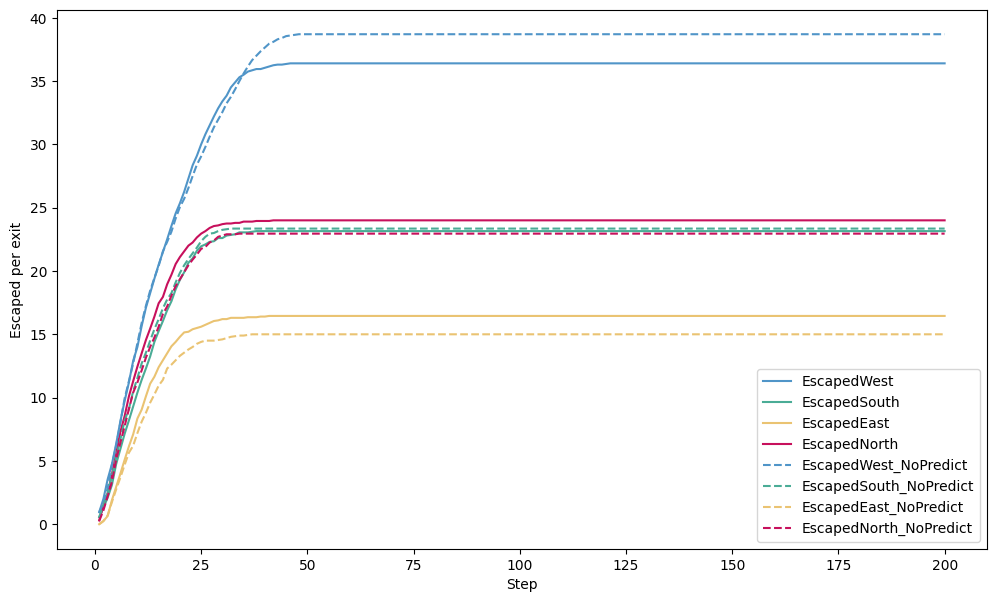

In [10]:
data = pd.DataFrame(results)
data = data[data['random_spawn']==False][['predictcrowd', 'Step', 'seed','EscapedWest', 'EscapedSouth','EscapedEast', 'EscapedNorth']]

# extend steps to max_steps grouped by seed and predictgrowd
data = data.groupby(data['Step'].diff().lt(1).cumsum()) \
    .apply(lambda x: x.set_index('Step').reindex(range(1, 201)).transform(lambda x: x.fillna(x.max()))) \
    .reset_index(level=0, drop=True) \
    .reset_index()

fig, ax = plt.subplots(figsize=(12, 7))
ax.set_ylabel("Escaped per exit")
data[data['predictcrowd']==True].groupby(['Step']).agg("mean").drop(columns=['predictcrowd', 'seed']).plot(ax=ax, colormap=uniks, ls="solid")
db = data[data['predictcrowd']==False].groupby(['Step']).agg("mean").drop(columns=['predictcrowd', 'seed'])
db.columns = ['EscapedWest_NoPredict', 'EscapedSouth_NoPredict','EscapedEast_NoPredict', 'EscapedNorth_NoPredict']
plot = db.plot(ax=ax, colormap=uniks, ls="dashed")

You may also want to analyse the escapes through the various exits:

**Describe your finding here (learn about Markdown syntax via Menu > Help > Markdown Reference)!**

parameters are the same as for the test above, but we are now looking at the number of agents escaping through each exit.

# results
- up to 20 steps the exits have roughly the same number of agents escaping
- model.py line 119: the floor is rotated by 90 degrees clockwise
- since there is no random spawn, the agents are spawned in the upper left part of the room

Since the room is rotated by 90 degrees clockwise, the west exit is now the north exit and the north exit is now the east exit.
For visualization purposes, the exits are still labeled as north, south, east, and west (they have to be translated to their real orientation in order to correspond to the plot above).

Assuming with no random spawn the agents are close to the west and north exit, because the agents are spawned in the upper left part of the room, the number of agents initially planning escaping through the north exit is higher than the other exits. 
This is due to the fact that the north exit is the closest to the starting position of many agents.
The lower rows of the room are further away from the north exit and thus, these agents escape through the west and east exit

## Subtask 2.5

Find one other factor than crowd prediction (by variations in the according parameter) that has a significant impact on the evacutation time. Show appropriate plot(s) and explain the impact shortly (<100 words).

In [11]:
params = dict(
    floor_size=14,
    human_count=100,
    alarm_believers_prop = [0.1, 0.9],
    max_speed = [2, 20],    # if speed > path length, agents takes min(speed, path length) steps to reach its next target
    random_spawn = [True, False],
    predictcrowd = False,
    cooperation_mean = [0.2, 0.9],
    nervousness_mean = [0.5, 0.9],
    seed = [i for i in range(20)],   # 20 seeds 
)

results = batch_run(
        FireEvacuation,
        parameters=params,
        iterations = 1,
        max_steps = 200,
    )

  0%|          | 0/640 [00:00<?, ?it/s]

Analysing new factors for predictcrowd=False...
alarm_believers_prop// random_spawn = True: The difference in the number of people escaping through the Step exit is not significant.
alarm_believers_prop// random_spawn = True: The p-value of Step is:  0.2014903888333969
alarm_believers_prop// random_spawn = False: The difference in the number of people escaping through the Step exit is not significant.
alarm_believers_prop// random_spawn = False: The p-value of Step is:  0.9870665069517092


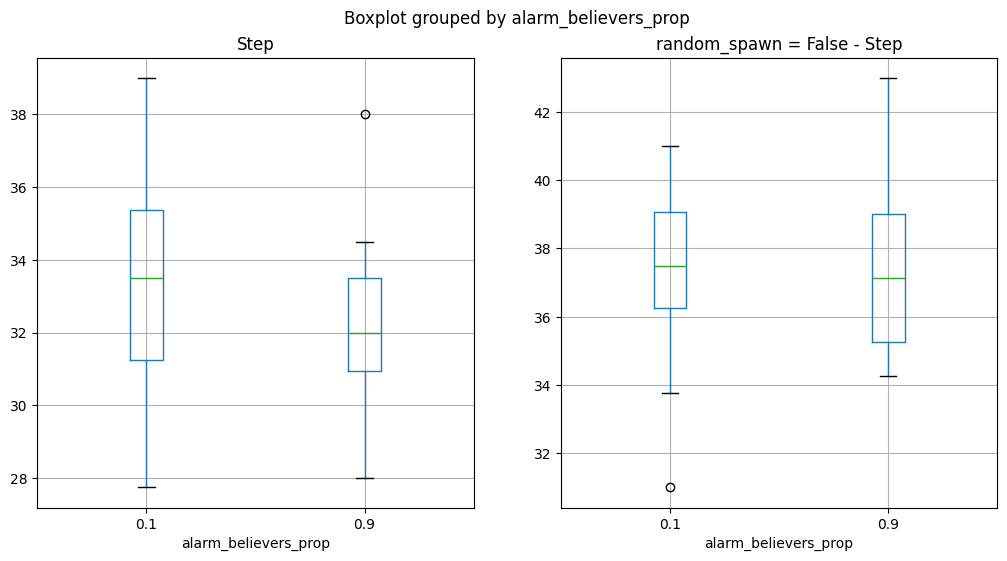

max_speed// random_spawn = True: The difference in the number of people escaping through the Step exit is not significant.
max_speed// random_spawn = True: The p-value of Step is:  1.0
max_speed// random_spawn = False: The difference in the number of people escaping through the Step exit is not significant.
max_speed// random_spawn = False: The p-value of Step is:  1.0


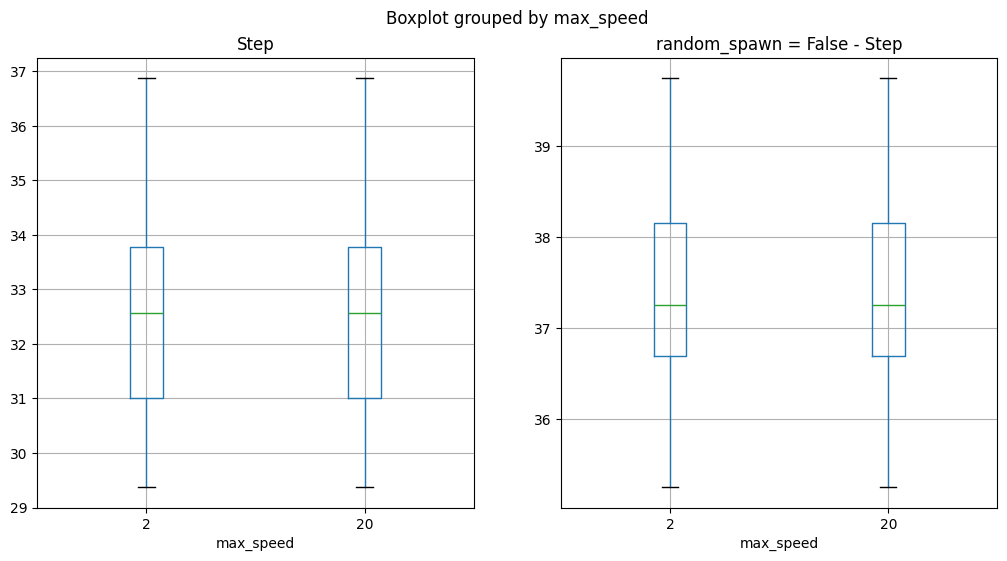

cooperation_mean// random_spawn = True: The difference in the number of people escaping through the Step exit is not significant.
cooperation_mean// random_spawn = True: The p-value of Step is:  0.440810702248446
cooperation_mean// random_spawn = False: The difference in the number of people escaping through the Step exit is not significant.
cooperation_mean// random_spawn = False: The p-value of Step is:  0.3579348108064645


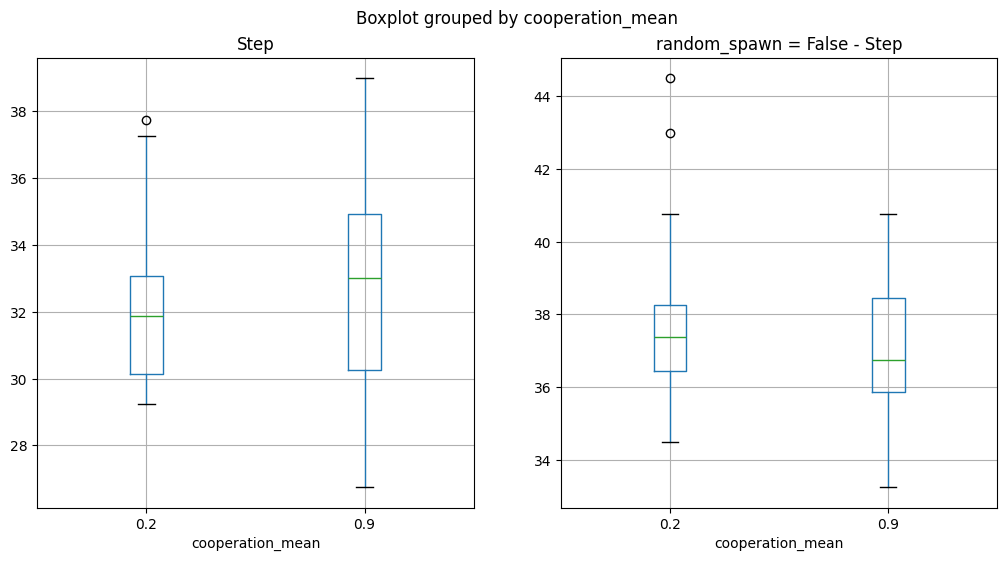

nervousness_mean// random_spawn = True: The difference in the number of people escaping through the Step exit is not significant.
nervousness_mean// random_spawn = True: The p-value of Step is:  0.83591064020043
nervousness_mean// random_spawn = False: The difference in the number of people escaping through the Step exit is significant.
nervousness_mean// random_spawn = False: The p-value of Step is:  0.003663765650235329


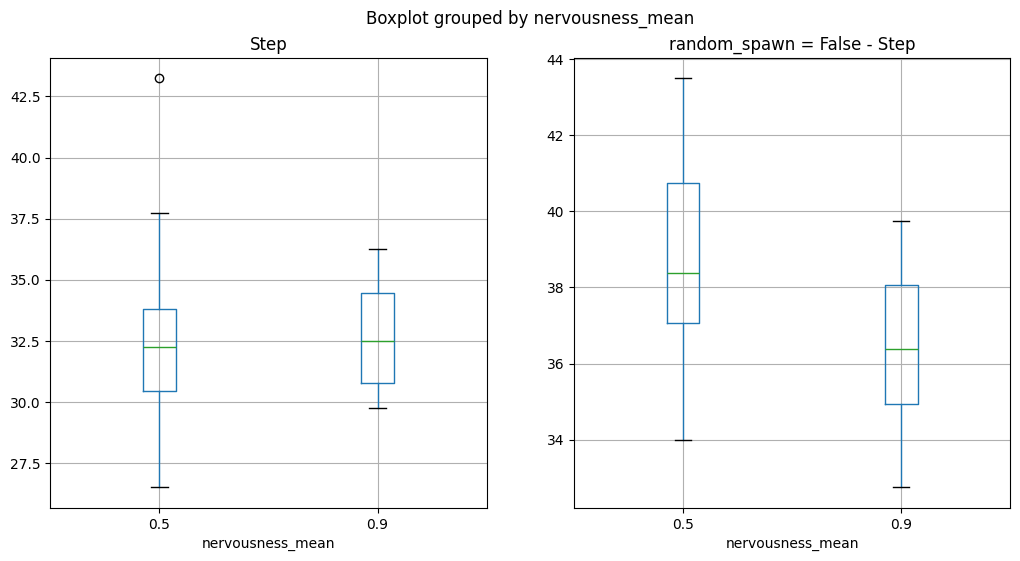

In [12]:
from scipy import stats

def analyse_significance_predictcrowd(data, title=""):

    print(f"Analysing {title}...")
    
    for factor in ['alarm_believers_prop', 'max_speed', 'cooperation_mean', 'nervousness_mean']:
        factor_data = data.groupby([factor, "seed", "random_spawn"]).agg("mean").reset_index()
        
        # implement t-test
        # predict_crowd vs no_predict_crowd
        samples1 = factor_data[(factor_data[factor]==params[factor][0])][['Step', 'random_spawn']]
        samples2 = factor_data[(factor_data[factor]==params[factor][1])][['Step', 'random_spawn']]
        

        t_test_stats = pd.DataFrame()
        for orientation in ['Step']: 
            fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
            for rand_spawn in [True, False]:
                rvs1 = samples1[(samples1['random_spawn']==rand_spawn)]
                rvs2 = samples2[(samples2['random_spawn']==rand_spawn)]
                t_test_stats[orientation] = stats.ttest_ind(rvs1[orientation], rvs2[orientation])
            
            # Interpret the results:
            # print appropriate messages about the t-test result, giving the level of significance
                if t_test_stats[orientation][1] < 0.10: # p-value
                    print(f"{factor}// random_spawn = {rand_spawn}: The difference in the number of people escaping through the {orientation} exit is significant.")
                else:
                    print(f"{factor}// random_spawn = {rand_spawn}: The difference in the number of people escaping through the {orientation} exit is not significant.")
                print(f"{factor}// random_spawn = {rand_spawn}: The p-value of {orientation} is: ", t_test_stats[orientation][1])
                
                factor_data[(factor_data['random_spawn']==rand_spawn)].boxplot(column=[orientation], by=factor, figsize = (12,6), ax=ax1 if rand_spawn else ax2)
            plt.title(f"random_spawn = {rand_spawn} - {orientation}")
            plt.show()
    None

data = pd.DataFrame(results)
analyse_significance_predictcrowd(data, title=f"new factors for predictcrowd={params['predictcrowd']}")

# predictcrowd = False

Since only the nervousness mean t-test (without random spawn) is significant, we can conclude that none of the parameters, but this one has a significant impact on the evacuation time (number of steps).
This is logical, because without random spawn, the agents are spawned in the upper left part of the room and thus, the agents are in a crowded area and get nervous.

In [13]:
params = dict(
    floor_size=14,
    human_count=100,
    alarm_believers_prop = [0.1, 0.9],
    max_speed = [2, 20],
    random_spawn = [True, False],
    predictcrowd = True,
    cooperation_mean = [0.2, 0.9],
    nervousness_mean = [0.5, 0.9],
    seed = [i for i in range(20)],   # 20 seeds 
)

results = batch_run(
        FireEvacuation,
        parameters=params,
        iterations = 1,
        max_steps = 200,
    )

  0%|          | 0/640 [00:00<?, ?it/s]

Analysing new factors for predictcrowd=True...
alarm_believers_prop// random_spawn = True: The difference in the number of people escaping through the Step exit is not significant.
alarm_believers_prop// random_spawn = True: The p-value of Step is:  0.11201836103728778
alarm_believers_prop// random_spawn = False: The difference in the number of people escaping through the Step exit is not significant.
alarm_believers_prop// random_spawn = False: The p-value of Step is:  0.17420397603201426


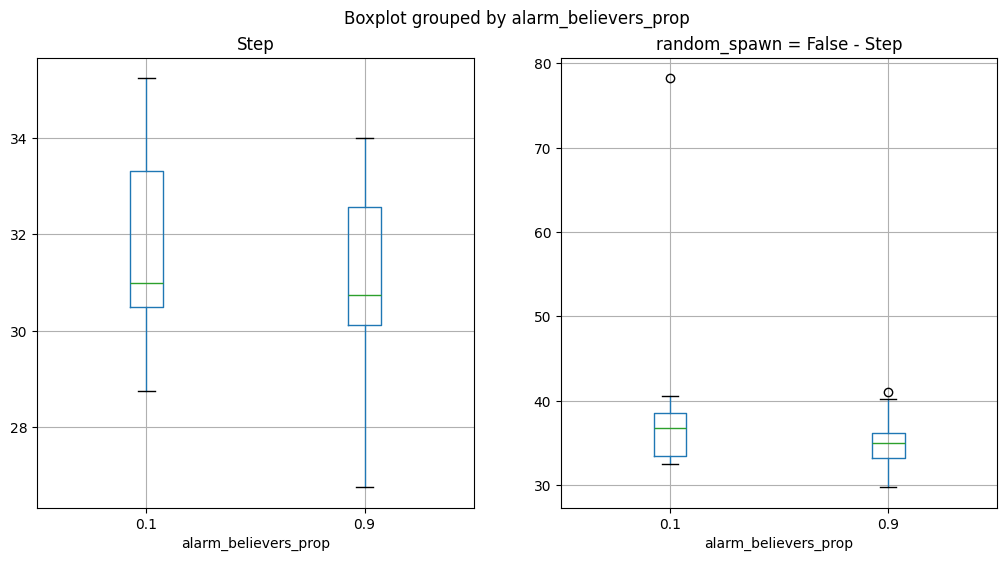

max_speed// random_spawn = True: The difference in the number of people escaping through the Step exit is not significant.
max_speed// random_spawn = True: The p-value of Step is:  1.0
max_speed// random_spawn = False: The difference in the number of people escaping through the Step exit is not significant.
max_speed// random_spawn = False: The p-value of Step is:  1.0


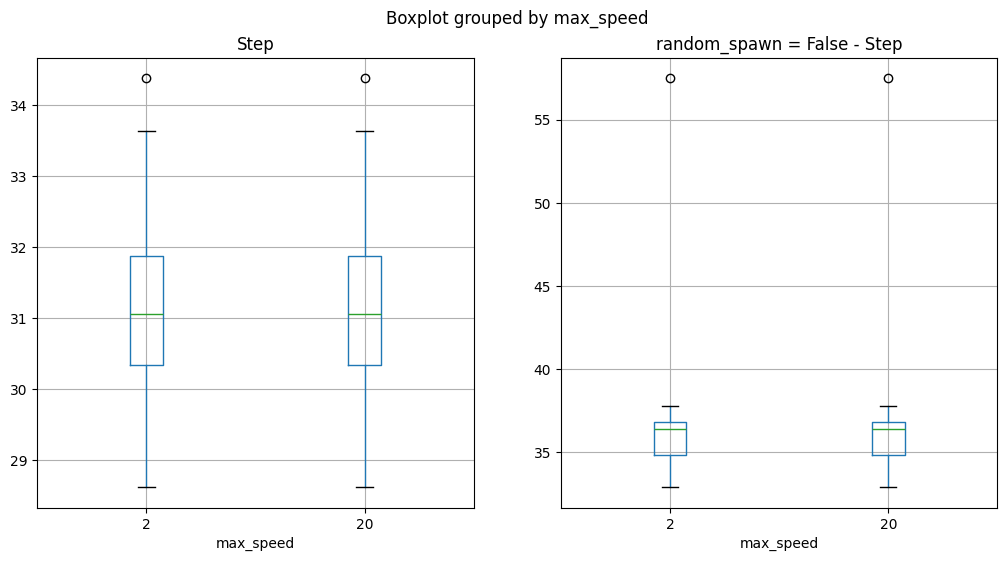

cooperation_mean// random_spawn = True: The difference in the number of people escaping through the Step exit is not significant.
cooperation_mean// random_spawn = True: The p-value of Step is:  0.7961781799123234
cooperation_mean// random_spawn = False: The difference in the number of people escaping through the Step exit is not significant.
cooperation_mean// random_spawn = False: The p-value of Step is:  0.45027389361878456


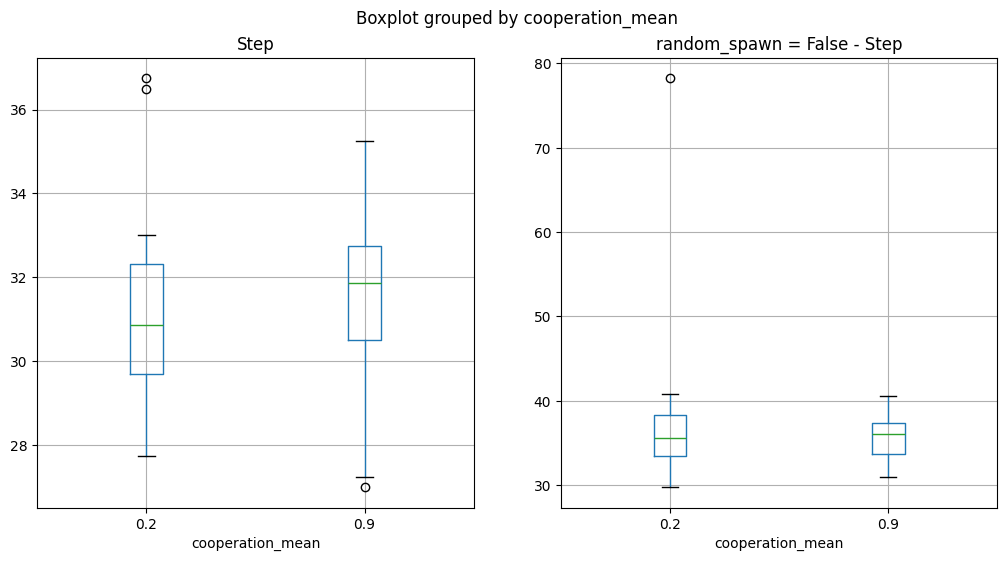

nervousness_mean// random_spawn = True: The difference in the number of people escaping through the Step exit is not significant.
nervousness_mean// random_spawn = True: The p-value of Step is:  0.40307364390329625
nervousness_mean// random_spawn = False: The difference in the number of people escaping through the Step exit is not significant.
nervousness_mean// random_spawn = False: The p-value of Step is:  0.6449596286263076


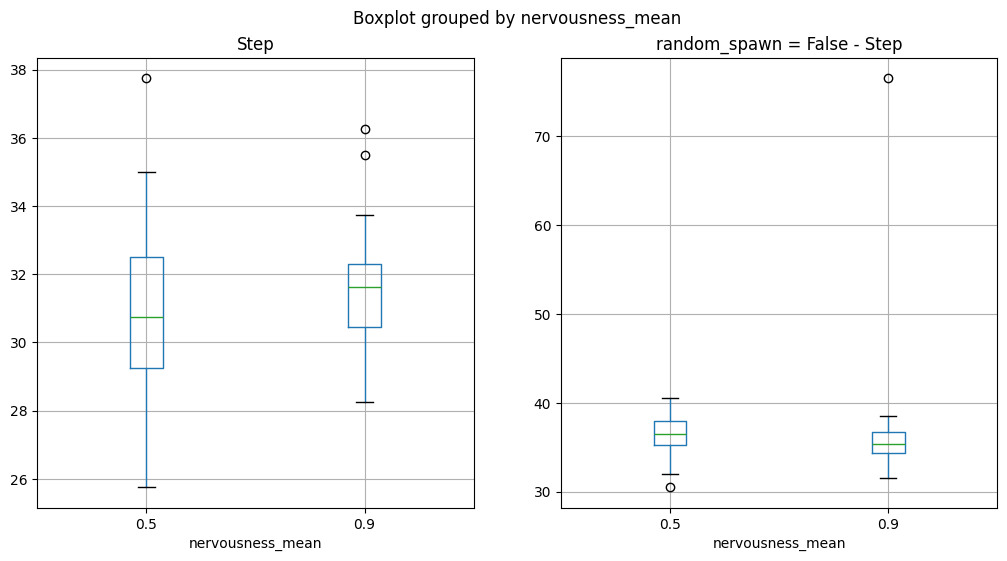

In [14]:
data = pd.DataFrame(results)
analyse_significance_predictcrowd(data, title=f"new factors for predictcrowd={params['predictcrowd']}")

# predictcrowd = True

Since all t-tests are non-significant, we can conclude that none of the parameters have a significant impact on the evacuation time (number of steps).

# Task 3 (Exploring learning in the evacuation model)

Agents can learn over time from past experience, and change their decision-making methods (the algorithms or perhaps only the parameters of those algorithms) as a consequence of their experience. When learning, agents seek to improve their behaviour according to an objective function.

In the evacuation model, the objective relates to the time it takes for an agent to escape the room. In this exercise, we're going to have the agents learn optimal values of cooperativeness. Therefore, agents memorise their cooperativeness and the time it takes them to leave the room. At the beginning, cooperation is changed randomly. After the memory is filled, agents identify the best evacuation (in terms of how long it takes until they escaped), choose the according cooperativeness value, and change it slightly to improve further:

```python
def learn(self):        
    if not self.memory is None:
        lastcooperativeness = self.memory[self.memory['rep'] == max(self.memory['rep'])]['cooperativeness'].iloc[0]

        if self.model.modelrun < self.memorysize or self.model.rngl.random() < Human.COOPERATIVENESS_EXPLORATION:
            self.cooperativeness = lastcooperativeness + Human.COOPERATIVENESS_CHANGE * self.model.rngl.uniform(-1.0,1.0)
        else:
            # determine best cooperativeness:
            try:
                bestcooperativeness = self.memory[
                    self.memory['numsteps2escape'] == min(
                        self.memory[(self.memory['rep'] > (max(self.memory['rep']) - self.memorysize))]
                        ['numsteps2escape'])]['cooperativeness'].iloc[0]    
            except:
                pass                                     
            self.cooperativeness = lastcooperativeness + (bestcooperativeness - lastcooperativeness) * \
                Human.COOPERATIVENESS_CHANGE

## Subtask 3.1

Describe the meaning of the two parameter `COOPERATIVENESS_EXPLORATION` and `COOPERATIVENESS_CHANGE`. What makes learning difficult in the evacuation model? Discuss two reasons (think of determinism/path-dependency and coordination) (<200 words).

    COOPERATIVENESS_EXPLORATION = 0.0
    COOPERATIVENESS_CHANGE = 0.2
    
Execute the following code:

In [15]:
from mesa.batchrunner import batch_run
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.insert(0,'../../abmodel')

from fire_evacuation.model import FireEvacuation
from fire_evacuation.agent import Human


unikcolors = [np.array((80,149,200))/255, np.array((74,172,150))/255,
                                                  np.array((234,195,114))/255, np.array((199,16,92))/255]
uniks = LinearSegmentedColormap.from_list( 'unik', unikcolors)

def run_model(model_a, model_b, maxsteps = 100):
    fig = plt.figure(figsize=(12, 12))
    model_a.run(maxsteps)
    model_b.run(maxsteps)
    
    ax = fig.add_subplot(2, 1, 2)
    ax.set_xlabel("Steps")
    ax.set_ylabel("Number of escaped through the exit")
    da = model_a.datacollector.get_model_vars_dataframe()[['EscapedWest', 'EscapedSouth','EscapedEast', 'EscapedNorth']]
    db = model_b.datacollector.get_model_vars_dataframe()[['EscapedWest', 'EscapedSouth','EscapedEast', 'EscapedNorth']]
    db.columns = ['EscapedWest_B', 'EscapedSouth_B','EscapedEast_B', 'EscapedNorth_B']
    da.plot(ax=ax, colormap=uniks, ls="solid")
    db.plot(ax=ax, colormap=uniks, ls="dashed")

When commenting in the line

`memories = memories[memories['agent'].values == observedAgent]`

learning only applies to `observedAgent`.

In [16]:
from IPython.utils import io
observedAgent = 7

evacuation = FireEvacuation(floor_size = 14,
        human_count = 90,
        alarm_believers_prop = 0.7,
        max_speed = 2,
        cooperation_mean = 0.3,
        nervousness_mean = 0.5,
        predictcrowd = True,
        agentmemorysize = 7,
        seed = 3)

# Run the model
evacuation.run(100)

# Store the agent memory
memories = evacuation.get_agentmemories()
#Allow learning only for observed agent if commented in
memories = memories[memories['agent'].values == observedAgent]

# Rerun the model starting with state of agents' memory of last run
for _ in range(0,20):
    evacuation = FireEvacuation(floor_size = 14,
            human_count = 70,
            alarm_believers_prop = 1.0,
            max_speed = 2,
            cooperation_mean = 0.3,
            nervousness_mean = 0.5,
            predictcrowd = True,
            agentmemories = memories,
            agentmemorysize = 7,
            seed = 3)
    evacuation.run(100)
    memories = evacuation.get_agentmemories()
    #Allow learning only for observed agent if commented in
    #memories = memories[memories['agent'].values == observedAgent]
    counter = 0
    steps2escape = 0
    cooperativeness = 0
    for agent in evacuation.schedule.agents:
        if isinstance(agent, Human):
            counter +=1
            steps2escape += agent.numsteps2escape
            cooperativeness += agent.cooperativeness

    print(f"Avg. steps to escape: {steps2escape/counter:.2f} | cooperativeness: {cooperativeness/counter:.2f}"
          f" | last step: {evacuation.schedule.steps}")

Avg. steps to escape: 8.16 | cooperativeness: 0.47 | last step: 24
Avg. steps to escape: 8.43 | cooperativeness: 0.48 | last step: 26
Avg. steps to escape: 8.31 | cooperativeness: 0.48 | last step: 23
Avg. steps to escape: 8.04 | cooperativeness: 0.49 | last step: 21
Avg. steps to escape: 8.77 | cooperativeness: 0.50 | last step: 23
Avg. steps to escape: 8.81 | cooperativeness: 0.51 | last step: 24
Avg. steps to escape: 8.24 | cooperativeness: 0.51 | last step: 21
Avg. steps to escape: 8.81 | cooperativeness: 0.51 | last step: 24
Avg. steps to escape: 8.31 | cooperativeness: 0.50 | last step: 21
Avg. steps to escape: 8.31 | cooperativeness: 0.50 | last step: 21
Avg. steps to escape: 8.53 | cooperativeness: 0.50 | last step: 26
Avg. steps to escape: 8.60 | cooperativeness: 0.50 | last step: 34
Avg. steps to escape: 8.80 | cooperativeness: 0.51 | last step: 26
Avg. steps to escape: 9.66 | cooperativeness: 0.51 | last step: 27
Avg. steps to escape: 9.66 | cooperativeness: 0.51 | last step

,rep,agent,cooperativeness,numsteps2escape
0,1,3,0.334163,2
0,2,3,0.367028,2
0,3,3,0.399893,2
0,4,3,0.432758,2
0,5,3,0.465623,2
0,6,3,0.498487,2
0,7,3,0.531352,5
0,8,3,0.491914,2
0,9,3,0.460364,2
0,10,3,0.435124,2


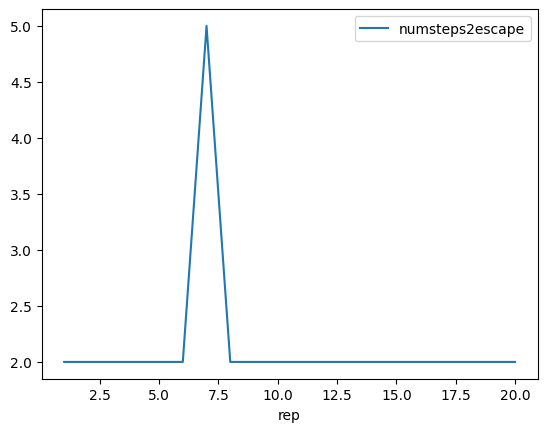

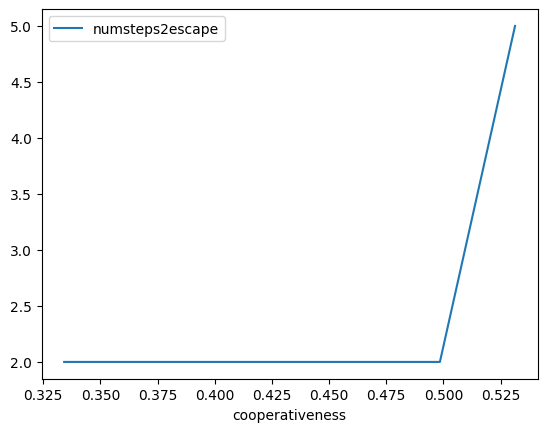

In [17]:
# You may want to expore single agent's memory. Note that only the last *memorysize* entries are considered.
observedAgent = 3   # agent id
memories = evacuation.get_agentmemories()
df = memories[memories['agent'].values==observedAgent]
df.sort_values('rep').set_index('rep').drop(columns=['cooperativeness','agent']).plot() # repetition/ iteration
df.sort_values('cooperativeness').set_index('cooperativeness').drop(columns=['rep','agent']).plot()
df

,rep,agent,cooperativeness,numsteps2escape
0,1,10,0.489854,1
0,2,10,0.446345,1
0,3,10,0.402836,1
0,4,10,0.359327,1
0,5,10,0.315819,1
0,6,10,0.272310,1
0,7,10,0.228801,1
0,8,10,0.281012,1
0,9,10,0.322780,1
0,10,10,0.356195,1


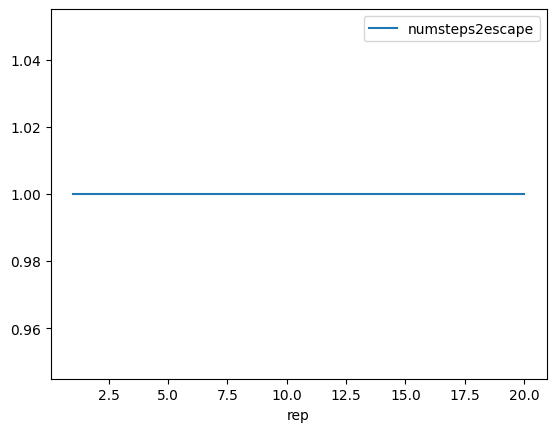

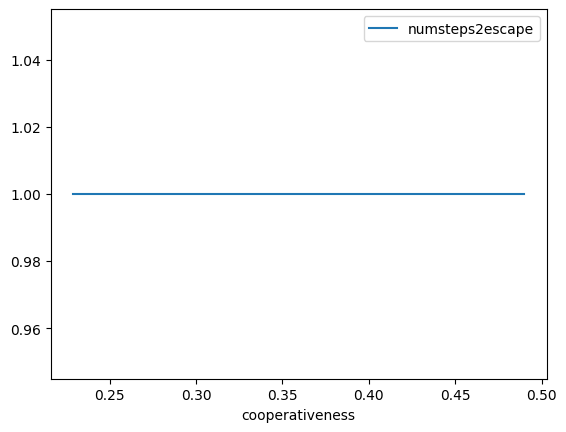

In [18]:
# You may want to expore single agent's memory. Note that only the last *memorysize* entries are considered.
observedAgent = 10
memories = evacuation.get_agentmemories()
df = memories[memories['agent'].values==observedAgent]
df.sort_values('rep').set_index('rep').drop(columns=['cooperativeness','agent']).plot()
df.sort_values('cooperativeness').set_index('cooperativeness').drop(columns=['rep','agent']).plot()
df

As you may observe, the implemented way of learning is not always successful. What makes learning difficult in the evacuation model? Discuss two reasons (think of determinism/path-dependency and coordination) (<200 words).

# meaning of the two parameter
- COOPERATIVENESS_EXPLORATION: probability that the agent explores new values of cooperativeness starting from last cooperativeness value
- COOPERATIVENESS_CHANGE: 
    - if exploration: the maximum amount by which the cooperativeness value is changed (positive or negative) if the agent explores new values of cooperativeness
    - if no exploration: the factor by which the cooperativeness value is adjusted towards the best known cooperativeness value starting from last cooperativeness value

# difficulties in learning
- determinism/path-dependency: the agents' decisions are based on the current state of the model and the agents' memory. If the agents' memory is not filled with enough data, the agents' decisions are based on deterministic random values (because of seed) of cooperativeness.
- coordination: interactions between agents are not taken into account in the learning process. Agents do not learn from the behavior of other agents and thus, the agents' decisions are only based on own experience. 

## Subtask 3.2

Find arguments pro and contra the statement that changing cooperativeness level in the evacuation model is learning (format as list)!

# pro
- random exploration of cooperativeness values
- agents adjust their cooperativeness value towards the best known cooperativeness value 

# contra
- the agents' decisions are not based on the behavior of other agents, but only on own experience
- there is only one strategy of adapting the cooperation value, no learning of new strategies